In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt


print(os.listdir('/kaggle/input/store-sales-time-series-forecasting/'))

['oil.csv', 'sample_submission.csv', 'holidays_events.csv', 'stores.csv', 'train.csv', 'test.csv', 'transactions.csv']


##  LightGBM baseline (V3)
This version is an attempt to simplify the features and approach after analyzing the shortcomings of previous models. 
Oil, transactions, first_sales_date have been discarded. The focus is on lag features, promo, calendar.


<!--Ця версія — спроба спростити фічі та підхід після аналізу недоліків попередніх моделей. 
Відкинуто oil, transactions, first_sales_date. Фокус — на lag-фічах, promo, календарі.-->

## Висновки з попередньої версії
- RMSLE в LGBM = 2.06, XGBoost = 2.66
- Найбільші проблеми: lag NaN, некорисний `oil`, шумні фічі
- Гіпотеза: надмірне ускладнення → спробуємо мінімалістичний baseline

#  Спрощений підхід: LightGBM + 10 фіч

  features_lgbm = [
    'month', 'dayofweek', 'is_weekend',
    'onpromotion', 'promo_on_holiday',
    'sales_lag_1', 'sales_lag_7', 'sales_lag_14',
    'sales_rolling_mean_7', 'delta_lag_7_14'
]


categorical_features = ['store_nbr', 'family']



<div style="display:none">
    Пояснення українською для себе, непотрібне в публічному вигляді.
    
</div>
Читаємо данні тест , трейн та цільова змінна, 
    робимо перший погляд на них
    

In [2]:
df_train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
df_test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
df_submission = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')
print(f'Train:{df_train.shape}   Test:{df_test.shape}   submission:{df_submission.shape}' )

Train:(3000888, 6)   Test:(28512, 5)   submission:(28512, 2)


In [3]:
display(df_train.head())
display(df_test.tail())
display(df_submission.head())

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


,id,date,store_nbr,family,onpromotion
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9
28511,3029399,2017-08-31,9,SEAFOOD,0


,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


<!-- Коментар українською для себе -->
* Розмічаємо для об'єднання train/test1 Об'єднуємо дані для фічей і заповнення
* Створюємо цільову змінну, аналізуємо
* !!!!! цільова змінна збережена поки окремо

In [4]:
# Add a marker to identify which dataset each row belongs to
df_train['dataset'] = 'train'
df_test['dataset'] = 'test'

In [5]:
# Combine both datasets to apply feature engineering uniformly
full_df = pd.concat([df_train, df_test], axis=0, sort=False)
y = df_train['sales']
y.describe()

count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

<!-- Коментар українською для себе -->
* бачу багато нулів , можливо не всі магазини почали працювати з 2013-01-01 або були перрви на ремонт тощо
* !!!перевірити


In [6]:
df_train[['sales','date']].tail()

,sales,date
3000883,438.133,2017-08-15
3000884,154.553,2017-08-15
3000885,2419.729,2017-08-15
3000886,121.000,2017-08-15
3000887,16.000,2017-08-15


In [7]:
full_df.shape

(3029400, 7)

<!-- Коментар українською для себе -->
          нижче
* завантажуємо інші данні
* переглядаємо їх
* мерджимо зрозумілу інфу про магазини
* Перетворюємо колонку 'date' у формат дати/часу (наприклад, з текстового формату)

In [8]:
# Load additional data sources
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])

In [9]:
display(stores.head())
display(holidays.head())

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [10]:
# Merge auxiliary data with the main DataFrame using appropriate keys
full_df = full_df.merge(stores, on='store_nbr', how='left')


In [11]:
print(full_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029400 entries, 0 to 3029399
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
 6   dataset      object 
 7   city         object 
 8   state        object 
 9   type         object 
 10  cluster      int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 254.2+ MB
None


In [12]:
#  Convert the 'date' column to proper datetime format (from string or other types)
full_df['date'] = pd.to_datetime(full_df['date'])

<!-- Коментар українською для себе -->
          нижче
* аналізуємо можливості додаткових фіч

# holidays

<!-- для себе -->
* створим нову фічу свята пвд кожен конкретний магазин, враховуючи регіанальність та можливі переноси свят(Transfer)
* є такі значееня 'Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'
для цього
1.  Перетворюємо колонку 'date' у дата-формат для подальших об'єднань
2. Залишаємо лише релевантні свята (крім 'робочих днів')
3. Розділяємо свята по рівнях: національний, регіональний, місцевий
4.  Додаємо національні свята за датою
5.  Додаємо регіональні свята — якщо state збігається з locale_name
6. Додаємо місцеві свята — якщо city збігається з locale_name
7.  Узагальнюємо всі типи свят у єдину ознаку: 'чи це свято'(сумуємо всі отримані маркери, та замінюємо все що більше 1(є якіст свята) на 1)
8. Видаляємо допоміжні змінні після створення is_holiday


In [13]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [14]:
holidays.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [15]:
holidays.locale.unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [16]:
#  Convert the 'date' column in the holidays dataframe to proper datetime format
holidays['date'] = pd.to_datetime(holidays['date'])

#  Filter only relevant holidays (exclude 'Work Day' which are not actual holidays)
holidays_effective = holidays[
    (holidays['type'] != 'Work Day')
]

#  Split holidays by locale level: National / Regional / Local
holidays_national = holidays_effective[holidays_effective['locale'] == 'National']
holidays_regional = holidays_effective[holidays_effective['locale'] == 'Regional']
holidays_local    = holidays_effective[holidays_effective['locale'] == 'Local']

#  Merge national holidays by date only
full_df = full_df.merge(
    holidays_national[['date']].drop_duplicates().assign(is_holiday_nat=1),
    on='date', how='left'
)

#  Merge regional holidays by matching date + state (locale_name)
full_df = full_df.merge(
    holidays_regional[['date', 'locale_name']].drop_duplicates().assign(is_holiday_reg=1),
    left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left'
)

#  Merge local holidays by matching date + city (locale_name)
full_df = full_df.merge(
    holidays_local[['date', 'locale_name']].drop_duplicates().assign(is_holiday_loc=1),
    left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left'
)

# Aggregate holiday flags into a single binary feature (max 1)
full_df['is_holiday'] = (
    full_df[['is_holiday_nat', 'is_holiday_reg', 'is_holiday_loc']]
    .sum(axis=1)
    .clip(upper=1)
    .fillna(0)
    .astype(int)
)

# Drop temporary columns used during the merging process
full_df.drop(
    columns=['locale_name_x', 'locale_name_y', 'is_holiday_nat', 'is_holiday_reg', 'is_holiday_loc'],
    inplace=True,
    errors='ignore'  #  If column missing — ignore without error
)

In [17]:
full_df.head()

,id,date,store_nbr,family,sales,onpromotion,dataset,city,state,type,cluster,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,train,Quito,Pichincha,D,13,1
1,1,2013-01-01,1,BABY CARE,0.0,0,train,Quito,Pichincha,D,13,1
2,2,2013-01-01,1,BEAUTY,0.0,0,train,Quito,Pichincha,D,13,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,train,Quito,Pichincha,D,13,1
4,4,2013-01-01,1,BOOKS,0.0,0,train,Quito,Pichincha,D,13,1


In [18]:
# Ensure the 'date' column is in datetime format
full_df['date'] = pd.to_datetime(full_df['date'])

# Extract the month from the date
full_df['month'] = full_df['date'].dt.month

# Get the day of the week (Monday=0, Sunday=6)
full_df['dayofweek'] = full_df['date'].dt.dayofweek

# Flag weekends: 1 if Saturday or Sunday, else 0
full_df['is_weekend'] = full_df['dayofweek'].isin([5, 6]).astype(int)


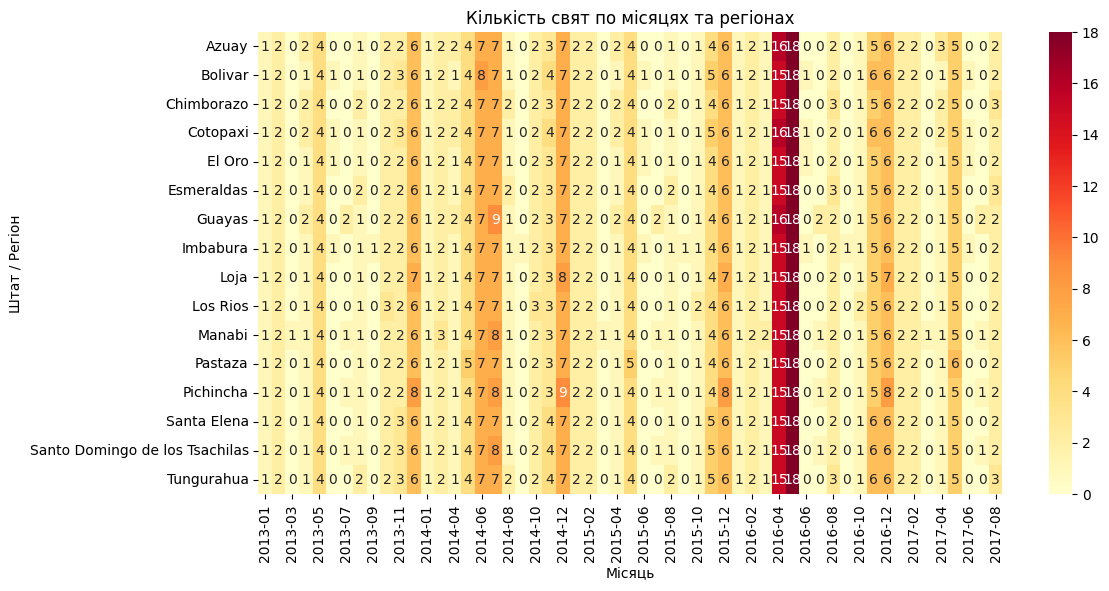

In [ ]:
# Select unique 'state' + 'date' combinations where a holiday occurs
unique_holidays = full_df[full_df['is_holiday'] == 1][['state', 'date']].drop_duplicates()

# Add a 'month' column (as a period) for accurate monthly grouping
unique_holidays['month'] = unique_holidays['date'].dt.to_period('M')

# Group by state and month, counting the number of distinct holiday dates
holiday_counts = (
    unique_holidays
    .groupby(['state', 'month'])
    .size()
    .unstack(fill_value=0)  # Reshape to have months as columns, fill missing with 0
)


#  heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(holiday_counts, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Кількість свят по місяцях та регіонах')
plt.xlabel('Місяць')
plt.ylabel('Штат / Регіон')
plt.show()


#  LightGBM model 

In [20]:
categorical_features = ['family', 'city', 'state', 'type', 'store_nbr', 'cluster']
features = ['month', 'dayofweek', 'is_weekend', 'is_holiday', 'onpromotion','family', 'city', 'state', 'type', 'store_nbr', 'cluster']

full_df[categorical_features] = full_df[categorical_features].astype('category')

# filter rows where dataset == 'train' or 'test'
train_df = full_df[full_df['dataset'] == 'train'].drop('sales', axis=1).copy()
test_df = full_df[full_df['dataset'] == 'test'].drop('sales', axis=1).copy()
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05,num_leaves=64)

X = train_df[features]
tscv = TimeSeriesSplit(n_splits=5)
def evaluate_model_cv(model, X_train, X_val, y_train, y_val, log_target=True):
    if log_target:
        model.fit(X_train, np.log1p(y_train))
        y_pred_log = model.predict(X_val)
        y_pred = np.expm1(y_pred_log)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

    y_pred = np.clip(y_pred, 0, None)
    rmsle = mean_squared_log_error(y_val, y_pred, squared=False)
    return rmsle, y_pred

rmsle_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    rmsle, y_pred = evaluate_model_cv(model, X_train, X_val, y_train, y_val, log_target=True)
    rmsle_scores.append(rmsle)

    print(f'Fold {fold+1} RMSLE: {rmsle:.4f} | Min prediction: {y_pred.min():.4f}')

avg_rmsle = np.mean(rmsle_scores)
print(f'\nAverage RMSLE over {tscv.get_n_splits()} folds: {avg_rmsle:.4f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 500148, number of used features: 10
[LightGBM] [Info] Start training from score 2.134970
Fold 1 RMSLE: 1.1230 | Min prediction: 0.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 1000296, number of used features: 11
[LightGBM] [Info] Start training from score 2.278712
Fold 2 RMSLE: 1.3083 | Min prediction: 0.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060728 

# 🧱 Model Foundation v1 — Minimum Viable Baseline
This model uses only the essential engineered features and categorical encoding.  
It achieves RMSLE ≈ 1.12, serving as a robust starting point for layered enhancement.


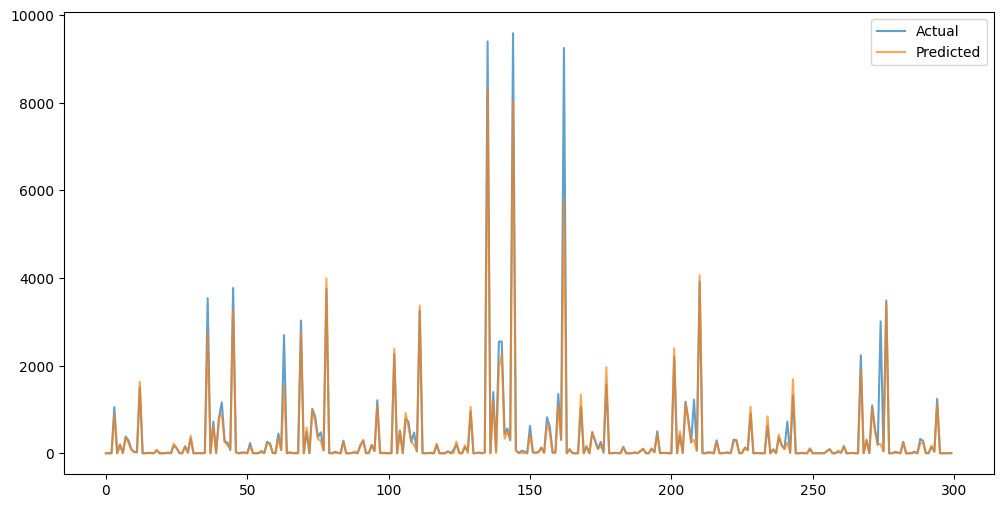

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.values[:300], label='Actual', alpha=0.7)
plt.plot(y_pred[:300], label='Predicted', alpha=0.7)
plt.legend()

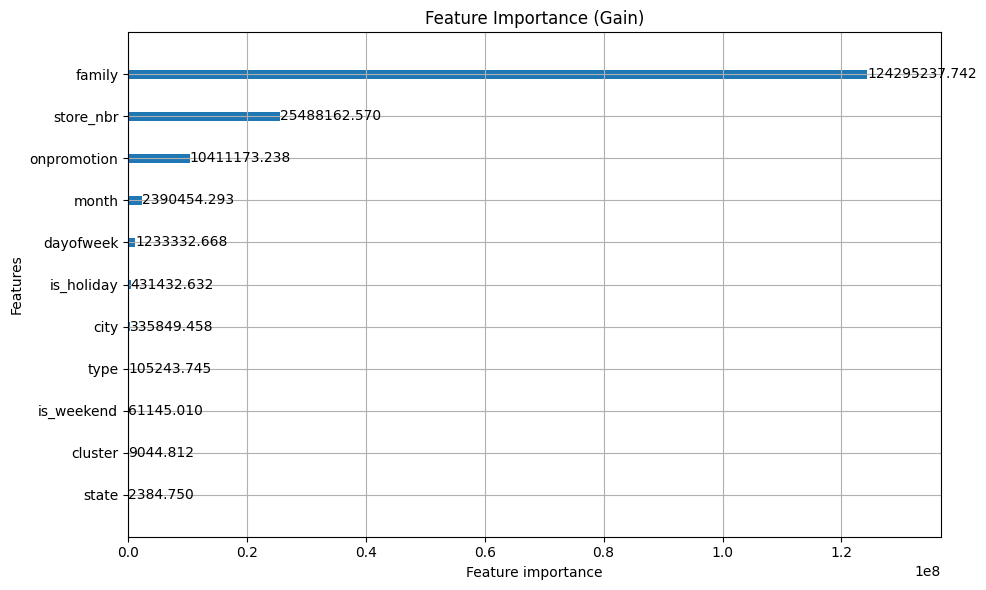

In [22]:
lgb.plot_importance(model, max_num_features=15, importance_type='gain', figsize=(10, 6))
plt.title("Feature Importance (Gain)")
plt.tight_layout()
plt.show()

# 🎯 SHAP Summary Plot – Feature Impact Explanation

This plot shows how each feature affects model predictions.  
Each dot is one training sample.

- **Y-axis**: Features (sorted by average impact on prediction)
- **X-axis**: SHAP value – how much this feature pushes the prediction up or down
- **Color**:
  - 🔵 Blue = Low feature value
  - 🔴 Red = High feature value
  - ⚫ Gray = Categorical or undetermined scale
- **Interpretation**:
  - If red dots are mostly on the right → high values of this feature increase predictions
  - If blue dots are on the left → low values decrease predictions
  - Long horizontal spread = strong influence
  - Vertical spread = how differently that feature behaves in different situations

<!--
Цей графік показує, як кожна фіча впливає на прогноз моделі.  
Кожна крапка — це один рядок з трейну.

- **Y-вісь**: Ознаки (впорядковані за важливістю для моделі)
- **X-вісь**: SHAP-значення — наскільки фіча змінила передбачення (вгору чи вниз)
- **Колір**:
  - 🔵 Синій = Низьке значення фічі
  - 🔴 Червоний = Високе значення фічі
  - ⚫ Сірий = Категоріальна або нефарбована фіча
- **Як читати**:
  - Якщо червоні точки праворуч → великі значення збільшують прогноз
  - Якщо сині зліва → малі значення зменшують
  - Широкий розкид по X → сильний вплив
  - Високий розкид по Y → фіча впливає по-різному в різних ситуаціях-->


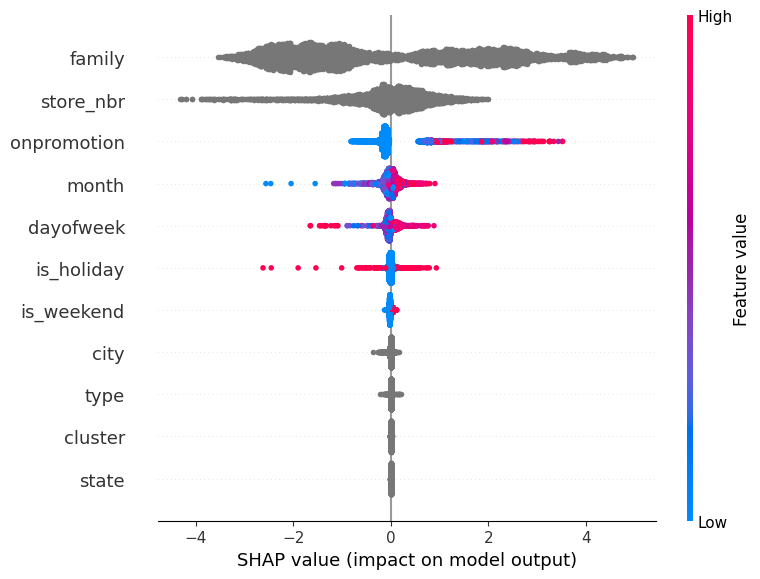

In [23]:
import shap

# Створюємо пояснювач
explainer = shap.TreeExplainer(model)

# Обираємо підмножину для аналізу (щоб не зависло)
sample = train_df[features].sample(5000, random_state=42)

# Обчислюємо SHAP-значення
shap_values = explainer.shap_values(sample)

# Побудова summary plot
shap.summary_plot(shap_values, sample, max_display=15)


# Final Submission: Train on Full Data & Predict Test


In [24]:
# Train the final model on the entire training dataset using log-transformed target
model.fit(X, np.log1p(y))

# Prepare test features and make predictions in log scale
X_test = test_df[features]
y_test_pred_log = model.predict(X_test)

# Invert log-transformation to get predictions in original sales scale
y_test_pred = np.expm1(y_test_pred_log)

# Ensure no negative predictions (just in case)
y_test_pred = np.clip(y_test_pred, 0, None)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 383
[LightGBM] [Info] Number of data points in the train set: 3000888, number of used features: 11
[LightGBM] [Info] Start training from score 2.926368


submission

In [25]:
submission = df_submission.copy()
submission['sales'] = y_test_pred
submission.to_csv('submission.csv', index=False)


In [26]:
submission['sales'].describe()


count    28512.000000
mean       418.182404
std       1138.221969
min          0.000000
25%          1.462322
50%         18.272541
75%        251.058286
max      14397.663171
Name: sales, dtype: float64